In [2]:
from qulacs import *
from qulacs.gate import *
from qulacs.state import *
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermionpyscf import run_pyscf
from pyscf import fci

In [3]:
## basis,multiplicity,charge,geometry(原子種と原子の位置),descriptionを定義する．
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.7414 #Å単位
geometry = [["H",[0,0,0]],["H",[0,0,distance]],["H",[0,0,distance*2]],["H",[0,0,distance*3]]]
description  = "tmp"

from qulacs import Observable
from qulacs.observable import *

## OpenFermionのmolecular-dataを読み取る
molecule = MolecularData(geometry, basis, multiplicity, charge, description) #openfermionのMolecularDataをもとに
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)

## ハミルトニアンを生成する．
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

## ハミルトニアンをQulacsに使える形に直す
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

nqubit,nelectron = molecule.n_qubits,molecule.n_electrons
print(nqubit,nelectron)

### Hartree Fock State
def HF_state(nqubit,nelectron):
    state = QuantumState(nqubit)
    circuit = QuantumCircuit(nqubit)
    for i in range(nelectron):
        circuit.add_gate(X(i))
    circuit.update_quantum_state(state)
    return state

hf_energy = qulacs_hamiltonian.get_expectation_value(HF_state(nqubit,nelectron))
print("HF Energy: {} Hartree".format(hf_energy))

### FCI
exact_energy = molecule.fci_energy
print("Exact Energy: {} Hartree".format(exact_energy))

8 4
HF Energy: -2.098694001099146 Hartree
Exact Energy: -2.139799644722612 Hartree


## ポテンシャル曲線

In [4]:
def HF_state(nqubit,nelectron):
    state = QuantumState(nqubit)
    circuit = QuantumCircuit(nqubit)
    for i in range(nelectron):
        circuit.add_gate(X(i))
    circuit.update_quantum_state(state)
    return state


def h_chain_potential(distance,h_num):
    """
    calculate potential energy of molecule
    distance unit is Å
    """
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    geometry = []
    for h in range(h_num):
        geometry.append(["H",[0,0,distance*h]])
    description  = "tmp"
    
    ## OpenFermionのmolecular-dataを読み取る
    molecule = MolecularData(geometry, basis, multiplicity, charge, description) #openfermionのMolecularDataをもとに
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    nqubit,nelectron = molecule.n_qubits,molecule.n_electrons
    
    ## ハミルトニアンを生成する．
    fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
    jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
    qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))
    hf_energy = qulacs_hamiltonian.get_expectation_value(HF_state(nqubit,nelectron))
    exact_energy = molecule.fci_energy
    
    return hf_energy,exact_energy

In [5]:
import numpy as np

h_num = 4
distance = np.linspace(0.1,2.5,101) ###時間結構かかる(1101で4分くらい)
hf,exact = [],[]
for d in distance:
    result = h_chain_potential(d,h_num)
    hf.append(result[0])
    exact.append(result[1])

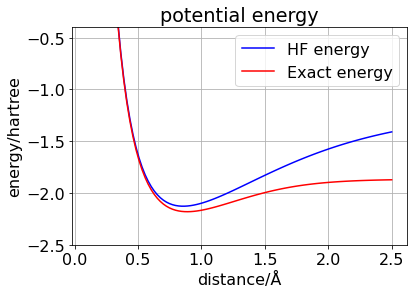

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

x=distance#定義域の設定
plt.plot(x,hf,color='blue',label="HF energy")
plt.plot(x,exact,color='red',label="Exact energy")


plt.title('potential energy')#title
plt.xlabel('distance/Å')
plt.ylabel('energy/hartree')

# 目盛線と目盛値を配列で指定．
## 目盛線の指定．
plt.grid()
##目盛値(及び目盛線)の指定．
plt.xticks()
plt.yticks()

plt.ylim([-2.5,-0.40])
plt.legend()
plt.show()